In [28]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, year, month, dayofmonth, dayofweek, weekofyear, avg, lag, when
from pyspark.sql.window import Window

In [29]:
spark = SparkSession.builder.appName("AirQualityAnalysisIndia").getOrCreate()

In [30]:
df_filled = spark.read.parquet('file:///home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/processed/cleaned_air_quality.parquet')

In [31]:
df_filled.groupBy("City").count().orderBy("count", ascending=False).show(10)

+-------------+-----+
|         City|count|
+-------------+-----+
|      Chennai| 2009|
|      Lucknow| 2009|
|       Mumbai| 2009|
|    Ahmedabad| 2009|
|        Delhi| 2009|
|    Bengaluru| 2009|
|    Hyderabad| 2006|
|        Patna| 1858|
|     Gurugram| 1679|
|Visakhapatnam| 1462|
+-------------+-----+
only showing top 10 rows


In [32]:
df_filled.groupBy("City").avg("PM25").orderBy("avg(PM25)", ascending=False).show(10)

+------------+------------------+
|        City|         avg(PM25)|
+------------+------------------+
|       Delhi|117.12781483325044|
|    Gurugram|110.81614651578315|
|       Patna|110.54996770721232|
|     Lucknow|106.60866600298674|
|    Guwahati| 63.65527888446214|
|     Kolkata| 63.29439803439806|
|   Ahmedabad| 61.82003982080687|
|Brajrajnagar| 60.99907249466969|
|     Talcher|58.848237837838006|
|    Amritsar| 54.74307125307148|
+------------+------------------+
only showing top 10 rows


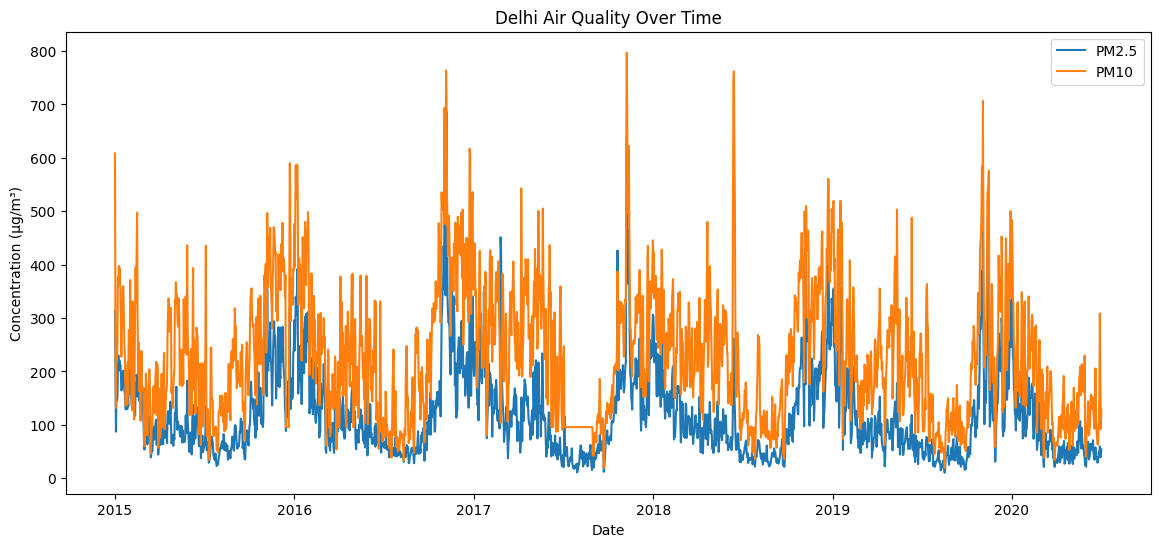

In [33]:
delhi_df = df_filled.filter(col("City") == "Delhi").select("Date", "PM25", "PM10").orderBy("Date")
delhi_pd = delhi_df.toPandas()

plt.figure(figsize=(14,6))
plt.plot(delhi_pd['Date'], delhi_pd['PM25'], label='PM2.5')
plt.plot(delhi_pd['Date'], delhi_pd['PM10'], label='PM10')
plt.title('Delhi Air Quality Over Time')
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')
plt.legend()
plt.show()

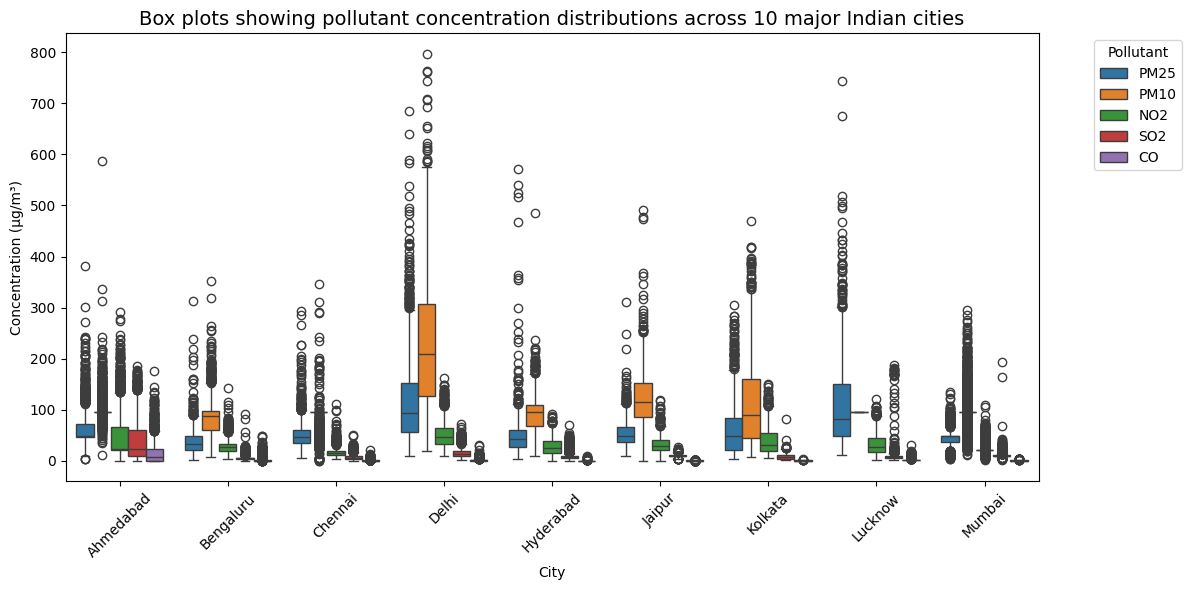

In [34]:
pollutants = ['PM25', 'PM10', 'NO2', 'SO2', 'CO']
pdf = df_filled.select('City', *pollutants).toPandas()

selected_cities = [
    'Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Bengaluru',
    'Hyderabad', 'Ahmedabad', 'Pune', 'Jaipur', 'Lucknow'
]
pdf = pdf[pdf['City'].isin(selected_cities)]

pdf_melted = pdf.melt(id_vars='City', var_name='Pollutant', value_name='Concentration')

plt.figure(figsize=(12, 6))
sns.boxplot(data=pdf_melted, x='City', y='Concentration', hue='Pollutant')
plt.title('Box plots showing pollutant concentration distributions across 10 major Indian cities', fontsize=14)
plt.xlabel('City')
plt.ylabel('Concentration (µg/m³)')
plt.xticks(rotation=45)
plt.legend(title='Pollutant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


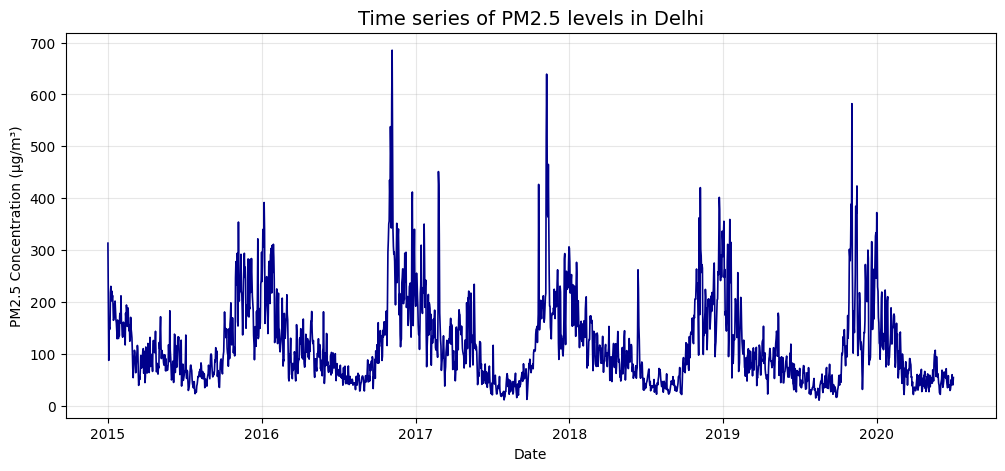

In [35]:
delhi_df = df_filled.filter(df_filled.City == 'Delhi').select('Date', 'PM25').toPandas()


delhi_df['Date'] = pd.to_datetime(delhi_df['Date'])
delhi_df = delhi_df.sort_values('Date')

plt.figure(figsize=(12, 5))
plt.plot(delhi_df['Date'], delhi_df['PM25'], color='darkblue', linewidth=1.2)
plt.title('Time series of PM2.5 levels in Delhi', fontsize=14)
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.grid(alpha=0.3)

plt.show()

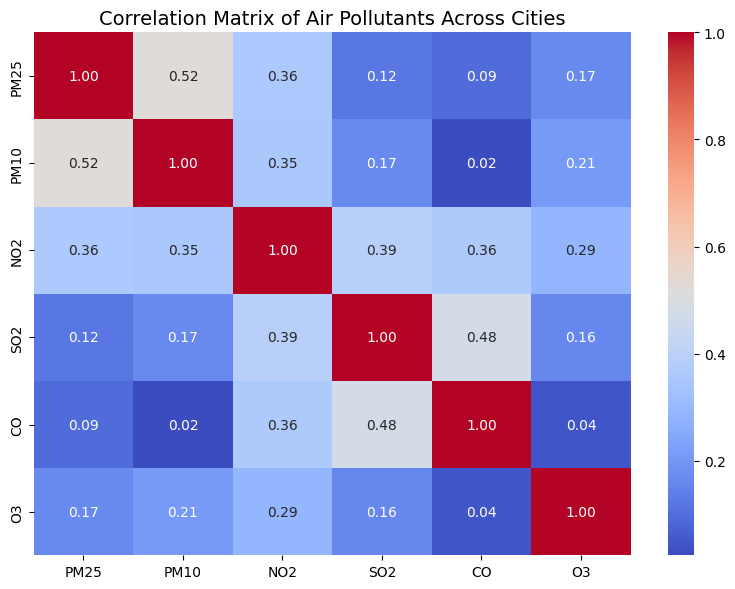

In [36]:
pollutants = ['PM25', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
pdf = df_filled.select(*pollutants).toPandas()

corr_matrix = pdf.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Air Pollutants Across Cities', fontsize=14)
plt.tight_layout()

plt.show()

/tmp/ipykernel_13752/3342888019.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x='City', y='PM25', palette='Set2')


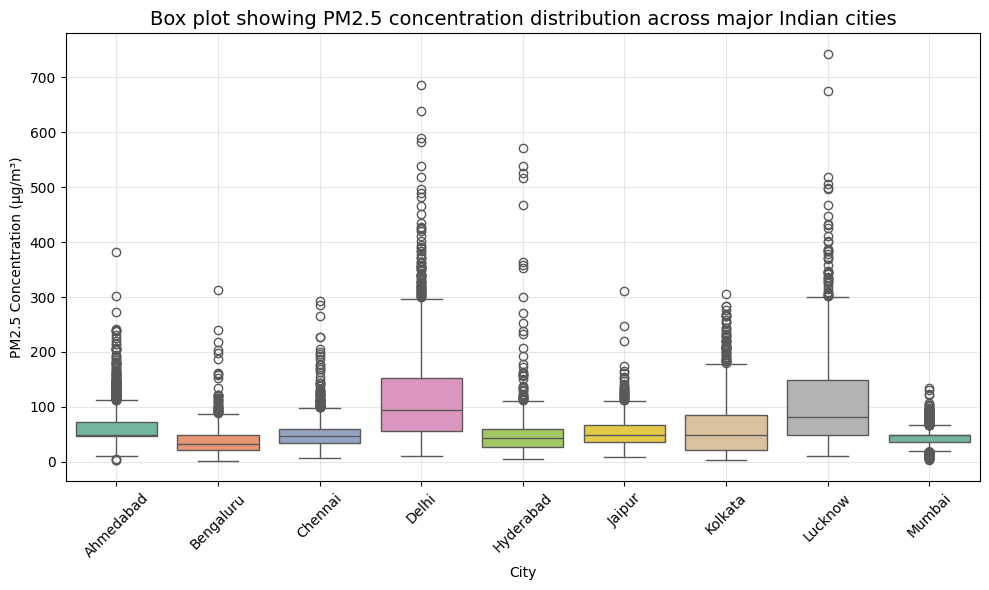

In [39]:

pdf = df_filled.select('City', 'PM25').toPandas()

selected_cities = [
    'Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Bengaluru',
    'Hyderabad', 'Ahmedabad', 'Pune', 'Jaipur', 'Lucknow'
]
pdf = pdf[pdf['City'].isin(selected_cities)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=pdf, x='City', y='PM25', palette='Set2')
plt.title('Box plot showing PM2.5 concentration distribution across major Indian cities', fontsize=14)
plt.xlabel('City')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig3_1_pm25_distribution_cities.png', dpi=300)
plt.show()


/tmp/ipykernel_13752/1249107503.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  delhi_monthly = delhi_df.resample('M', on='Date').mean().reset_index()


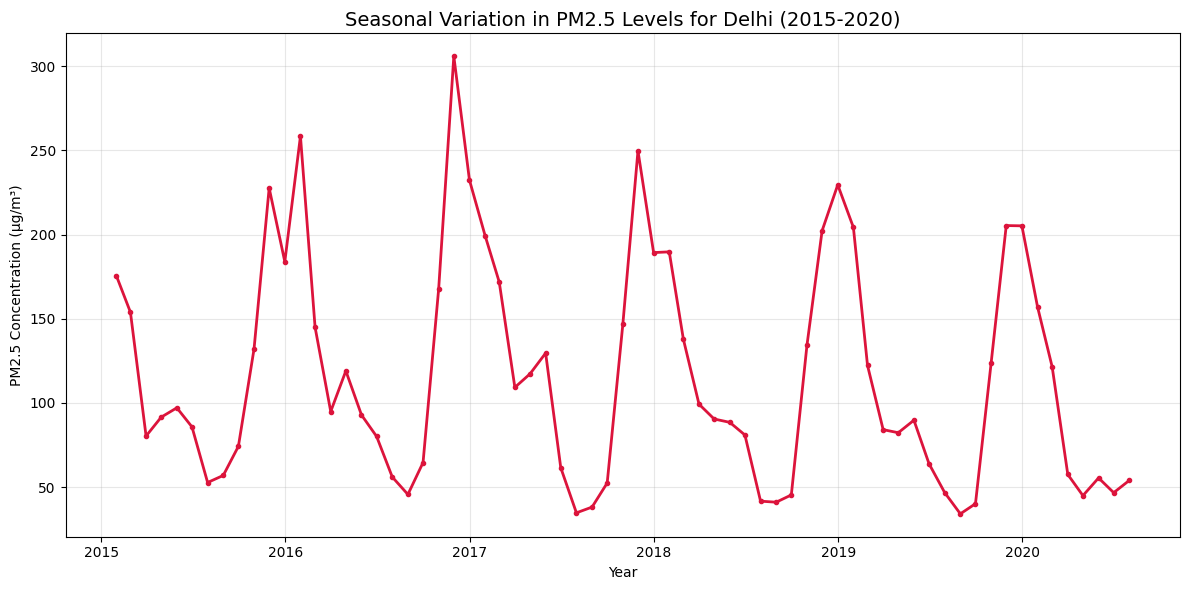

In [42]:
delhi_df = df_filled.filter(df_filled.City == 'Delhi').select('Date', 'PM25').toPandas()


delhi_df['Date'] = pd.to_datetime(delhi_df['Date'], errors='coerce')
delhi_df = delhi_df.dropna(subset=['Date', 'PM25'])

delhi_df = delhi_df[(delhi_df['Date'].dt.year >= 2015) & (delhi_df['Date'].dt.year <= 2020)]

delhi_monthly = delhi_df.resample('M', on='Date').mean().reset_index()


plt.figure(figsize=(12, 6))
plt.plot(delhi_monthly['Date'], delhi_monthly['PM25'], color='crimson', linewidth=2, marker='o', markersize=3)

plt.title('Seasonal Variation in PM2.5 Levels for Delhi (2015-2020)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [26]:
df_filled.write.mode("overwrite").parquet("file:///home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/processed/enriched_air_quality.parquet")

In [43]:
spark.stop()